<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center">Deep Learning Fundamentals</h2>
    <h2 align="center" style="color:#01ff84">Multiclass Clasification: MNIST</h2>
<div>

## Imports

In [28]:
#jupyter notebook settings not a must but helps
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# helps in defining a model in sequential 
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# dealing with images 
from torchvision import datasets, transforms

## Auxliary plotting function

In [3]:
# https://discuss.pytorch.org/t/view-classify-in-module-helper/30279/6

# for visualising samples, this helps to debug 
def view_classify(img, ps):

    ps = ps.data.numpy().squeeze() # Convert to numpy and remove the first dimension 

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Load MNIST Dataset
First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [26]:
# compose is like a pipleline, of the steps that we want to perform
# inituition is that transforms.ToTenso() converts the image to numpy then to tensor, PIL can be used to convert image to numpy array
# normalize is to normalize the image to be between 0 and 1
# transforms.Normalize((0.5), (0.5)) --> mean and std
# since data is grey scale we only need to specify the mean and std for the channel
#if we had colored then the function would be as transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# we don't want to pass all that data once, cause memory lol
# rule of thumb : small batch size = smaller learning rate, bigger batch size = bigger learning rate
# in theory a big batch size makes trainig faster , the updates may to be big and this impacts the model 

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
# shuffle is not necessary for test set, since we are not learning from it

In [5]:
# accessing the data
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

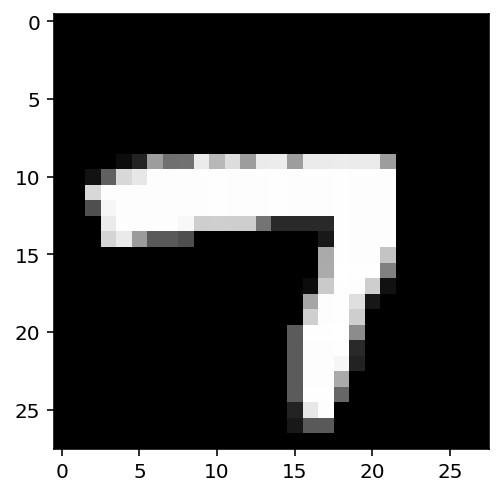

In [6]:
#plt.imshow(img) #this wont directly work since we have a 3rd dimension of the image
# we can use .squeeze() to remove the dimension of the image
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

<img src="assets/mlp_mnist.png" width=600px>

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets/activation.png" width=700px>

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [7]:
class Network(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Sequential API
PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [8]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size   = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


You can also pass in an `OrderedDict` to name the individual layers and operations. Note that a dictionary keys must be unique, so _each operation must have a different name_.

In [9]:
model = nn.Sequential(OrderedDict([
          ('fc1',   nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2',   nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('output', nn.Linear(hidden_sizes[1], output_size)),
          ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [10]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0280,  0.0185, -0.0120,  ...,  0.0268,  0.0127,  0.0062],
        [-0.0105,  0.0189, -0.0176,  ..., -0.0214,  0.0170,  0.0303],
        [-0.0234,  0.0355, -0.0139,  ...,  0.0326, -0.0184,  0.0248],
        ...,
        [ 0.0009,  0.0327,  0.0038,  ..., -0.0094,  0.0259, -0.0198],
        [-0.0075,  0.0251, -0.0181,  ...,  0.0077,  0.0049, -0.0049],
        [ 0.0270, -0.0239,  0.0260,  ..., -0.0238,  0.0009,  0.0077]],
       requires_grad=True)
Parameter containing:
tensor([-9.1504e-03,  2.5463e-02,  3.4291e-02,  3.5149e-02, -6.0324e-03,
         1.3167e-02, -2.5415e-02,  1.3753e-02, -1.6139e-02, -2.7262e-03,
         1.8210e-02,  2.4034e-04,  2.7118e-03,  1.5921e-02,  2.6082e-02,
         2.3475e-02, -2.0289e-02, -9.0711e-03, -2.4197e-02,  3.5699e-05,
         7.7649e-03,  3.2780e-02, -1.8187e-02, -3.0985e-02, -2.4679e-02,
        -3.0274e-03, -1.7236e-02, -3.3650e-02, -2.5198e-02, -1.5137e-02,
        -1.9697e-02,  3.1576e-03,  3.4298e-02,  2.7042e-0

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [11]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 2.3026e-03,  7.6569e-03, -1.7499e-02,  ..., -6.7111e-03,
         -1.6638e-03, -1.0608e-02],
        [ 8.7503e-05, -2.2068e-03,  5.1593e-03,  ..., -1.3214e-02,
          1.3040e-02, -8.8085e-03],
        [ 1.0759e-02,  1.2896e-03, -7.5887e-03,  ...,  7.7617e-03,
          1.2439e-02, -4.5779e-04],
        ...,
        [ 1.9980e-03,  9.7843e-03,  1.0171e-02,  ..., -2.3752e-03,
          8.9613e-03, -4.4510e-03],
        [-1.8107e-02,  1.1966e-02,  4.6102e-03,  ..., -9.2781e-04,
          1.6700e-02,  7.2786e-03],
        [-6.1680e-03,  7.9297e-03, -1.1664e-02,  ..., -1.0874e-02,
         -4.9156e-03,  6.8146e-03]])

### STEP 1: Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

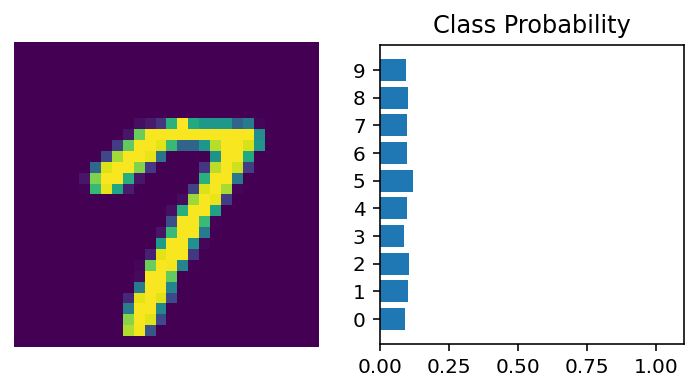

In [13]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

# Training Neural Networks

The network we built isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [14]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 0.7626,  0.3735],
        [-0.4046,  0.1331]], requires_grad=True)


In [15]:
y = x**2
print(y)

tensor([[0.5816, 0.1395],
        [0.1637, 0.0177]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [16]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [17]:
z = y.mean()
print(z)

tensor(0.2256, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [18]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [19]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.3813,  0.1868],
        [-0.2023,  0.0665]])
tensor([[ 0.3813,  0.1868],
        [-0.2023,  0.0665]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [20]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size  = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('logits', nn.Linear(hidden_sizes[1], output_size))]))

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [22]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[-0.0323, -0.0212,  0.0321,  ..., -0.0197, -0.0356, -0.0157],
        [-0.0298,  0.0220, -0.0279,  ...,  0.0060, -0.0148,  0.0252],
        [-0.0141,  0.0310,  0.0052,  ...,  0.0273,  0.0029,  0.0321],
        ...,
        [ 0.0228, -0.0047, -0.0354,  ..., -0.0280,  0.0340, -0.0221],
        [-0.0216,  0.0320,  0.0319,  ...,  0.0134, -0.0209,  0.0167],
        [ 0.0029, -0.0354, -0.0273,  ...,  0.0235, -0.0100,  0.0177]],
       requires_grad=True)
Gradient - tensor([[ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0038, -0.0038, -0.0038,  ..., -0.0038, -0.0038, -0.0038],
        ...,
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009]])


In [23]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[-0.0323, -0.0212,  0.0321,  ..., -0.0197, -0.0356, -0.0157],
        [-0.0298,  0.0220, -0.0279,  ...,  0.0060, -0.0148,  0.0252],
        [-0.0140,  0.0310,  0.0052,  ...,  0.0274,  0.0030,  0.0322],
        ...,
        [ 0.0228, -0.0047, -0.0355,  ..., -0.0280,  0.0340, -0.0221],
        [-0.0216,  0.0320,  0.0319,  ...,  0.0134, -0.0208,  0.0167],
        [ 0.0029, -0.0354, -0.0273,  ...,  0.0235, -0.0100,  0.0177]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [25]:
epochs = 3
print_every = 40

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0

Epoch: 1/3
	Iteration: 0	 Loss: 0.0577
	Iteration: 40	 Loss: 2.3032
	Iteration: 80	 Loss: 2.2852
	Iteration: 120	 Loss: 2.2694
	Iteration: 160	 Loss: 2.2553
	Iteration: 200	 Loss: 2.2405
	Iteration: 240	 Loss: 2.2223
	Iteration: 280	 Loss: 2.1968
	Iteration: 320	 Loss: 2.1703
	Iteration: 360	 Loss: 2.1454
	Iteration: 400	 Loss: 2.1124
	Iteration: 440	 Loss: 2.0836
	Iteration: 480	 Loss: 2.0414
	Iteration: 520	 Loss: 2.0021
	Iteration: 560	 Loss: 1.9465
	Iteration: 600	 Loss: 1.9064
	Iteration: 640	 Loss: 1.8596
	Iteration: 680	 Loss: 1.7910
	Iteration: 720	 Loss: 1.7301
	Iteration: 760	 Loss: 1.6778
	Iteration: 800	 Loss: 1.5979
	Iteration: 840	 Loss: 1.5207
	Iteration: 880	 Loss: 1.4646
	Iteration: 920	 Loss: 1.3832
Epoch: 2/3
	Iteration: 0	 Loss: 0.0324
	Iteration: 40	 Loss: 1.2748
	Iteration: 80	 Loss: 1.2074
	Iteration: 120	 Loss: 1.1784
	Iteration: 160	 Loss: 1.1062
	Iteration: 200	 Loss: 1.0829
	Iteration: 240	 Loss: 1.0215
	Iteration: 280	 Loss: 0.9602
	Iteration: 320	 Loss: 0.9

With the network trained, we can check out it's predictions.

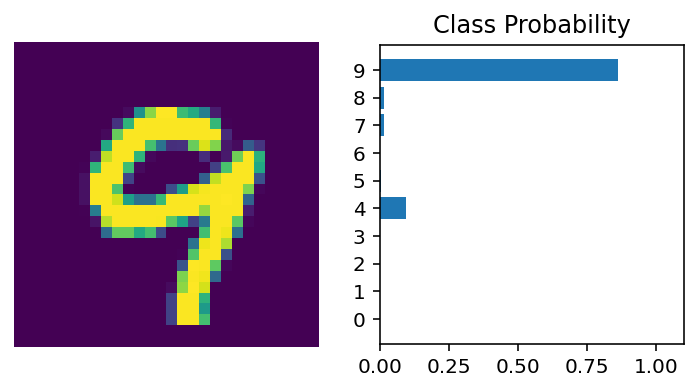

In [33]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images.

<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center" style="color:#01ff84">MNIST Clasification: Exercise</h2>
<div>

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 1:</h3>
  <p>Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.</p>
  <p>Build a network to classify the MNIST images with 3 hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer.</p>
<div>

In [80]:
# ## TODO: Your network here
    # what does nn.Module mean? well we are inheriting in the atrribute of nn.Module and methods of nn.Module
    # we then overwrite the constructor to define the network we want
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400) # input dim is 28x28 = 784 , value of output is defined by us, can be any number
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200,100)
        self.fc4 = nn.Linear(100, 10) # the 10 has to be the number of classes, we have 10 classes in this case
        

    # Forward pass through the network, in order to ensure the manner in which the data is being passed through the network, returns the output logits
    # relu performs better than sigmoid as it does not make the values smaller going through the network and we may lose information
    def forward(self, x):
        x = x.view(x.shape[0],784)  # flatten the input, can be done here, or in training loop
        x = self.fc1(x)
        x = F.relu(x) # ReLU is a non-linearity function, it is a function that returns the max of the input and 0.
        # here we are call it via F as it is a torch function, or you can define it in the method as we saw with sigmoid previously 
        x = self.fc2(x)
        x = F.relu(x) #activation function decides whether the nueron fires or not, i.e. passing data through the network
        x = self.fc3(x)
        x = F.relu(x) 
        x = self.fc4(x)
        output = F.softmax(x, dim=1) # to get the probability of each class, dim =1 is the dimension we want to apply softmax on
        return output


In [81]:
model = Network()
model


Network(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

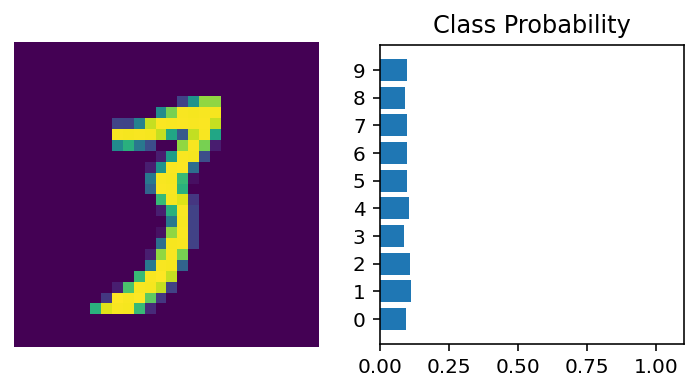

In [82]:
# Run this cell with your model to make sure it works
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 2:</h3>
  <p>Train your network implementing the Pytorch training loop and <strong style="color:#01ff84">after each epoch, use the model for predicting the test (validation) MNIST data.</strong></p>
  <p>Note: If your model does not fit with the final softmax layer, you can remove this layer.</p>
  <p>Hint: <a href="https://discuss.pytorch.org/t/training-loop-checking-validation-accuracy/78399">Training loop checking validation accuracy
</a></p>
  <p>Research about <code>model.train()</code>, <code>model.eval()</code> and <code>with torch.no_grad()</code> in Pytorch.
<div>

In [84]:
# training the model, you need to create this pretty much once adn you can use this over and over again the core is the 
# zero_grad() to the optimizer.step()

## TODO: Your training loop here
criterion = nn.CrossEntropyLoss() # this is the loss function, we use cross entropy loss as we are using softmax, we can get away with/without softmax
optimizer = optim.Adam(model.parameters(), lr=0.001) #smaller lr takes longer to converge, adam is adaptive momentum optimizer

epoch = 3
print_every = 40

for e in range(epoch):
    running_loss = 0
    test_loss = 0
    correct = 0
    print(f"Epoch: {e+1}/{epoch}")

    for i, (images, labels) in enumerate(iter(trainloader)): # tuple unpacking as we have both image and labels from the dataloader
        optimizer.zero_grad() # to clean the gradient else it will accumulate the gradients
                                    # pytorch by default saves the gradients using the autograd,so it can do backpropagation quickly, but for each step we 
                                    # want fresh gradients for each iter, so we need to clean the gradients

        output = model.forward(images) # Forward Pass
        loss = criterion(output, labels) # Calculating Loss
        loss.backward() # Backward Pass
        optimizer.step() # Updating the Weights in the Model

        running_loss += loss.item()

        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0 

    with torch.no_grad():
        for x, y in testloader:
         #   x.resize_(x.size()[0], 784)
            pred = model(x)
            test_loss += criterion(pred, y).item() # Computing the Loss on the test set
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Computing the number of correct predictions

        test_loss /= len(testloader) # Calculating Average Loss for the model
        correct /= len(testloader.dataset) # Calculating the Accuracy with total correct predictions and the total length of the dataset
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

print("Done !!!")

    


Epoch: 1/3
	Iteration: 0	 Loss: 0.0376
	Iteration: 40	 Loss: 1.5227
	Iteration: 80	 Loss: 1.5222
	Iteration: 120	 Loss: 1.5219
	Iteration: 160	 Loss: 1.5287
	Iteration: 200	 Loss: 1.5353
	Iteration: 240	 Loss: 1.5217
	Iteration: 280	 Loss: 1.5238
	Iteration: 320	 Loss: 1.5260
	Iteration: 360	 Loss: 1.5316
	Iteration: 400	 Loss: 1.5261
	Iteration: 440	 Loss: 1.5248
	Iteration: 480	 Loss: 1.5287
	Iteration: 520	 Loss: 1.5109
	Iteration: 560	 Loss: 1.5287
	Iteration: 600	 Loss: 1.5162
	Iteration: 640	 Loss: 1.5100
	Iteration: 680	 Loss: 1.5213
	Iteration: 720	 Loss: 1.5160
	Iteration: 760	 Loss: 1.5280
	Iteration: 800	 Loss: 1.5228
	Iteration: 840	 Loss: 1.5274
	Iteration: 880	 Loss: 1.5286
	Iteration: 920	 Loss: 1.5203
Test Error: 
 Accuracy: 94.5%, Avg loss: 1.515994 

Epoch: 2/3
	Iteration: 0	 Loss: 0.0382
	Iteration: 40	 Loss: 1.5143
	Iteration: 80	 Loss: 1.5182
	Iteration: 120	 Loss: 1.5282
	Iteration: 160	 Loss: 1.5145
	Iteration: 200	 Loss: 1.5218
	Iteration: 240	 Loss: 1.5152
	Ite

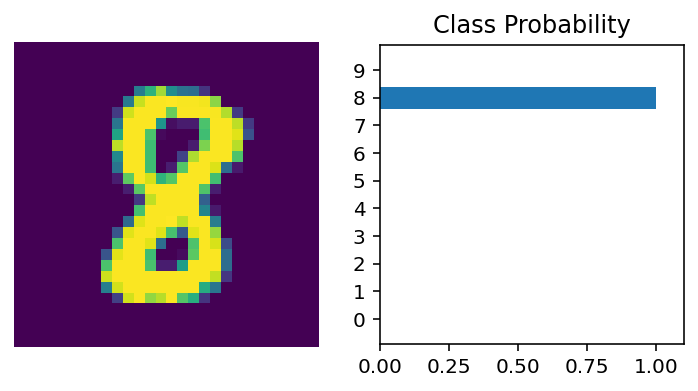

In [85]:
# Run this cell with your model to make sure it works and predicts well for the validation data
images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 3:</h3>
  <p>Write the code for adding <strong style="color:#01ff84">Early Stopping with patience = 2</strong> to the training loop from scratch.</p>
  <p><strong style="color:#01ff84">Hint:</strong> Monitor the Validation loss every epoch, and if in 2 epochs, the validation loss does not improve, stop the training loop with <code>break</code>.</p>
<div>

In [86]:
## TODO: Your training loop here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
validation_loss = np.inf # Set validation loss to higher value so that the first iteration always executes


epoch = 3
print_every = 40

for e in range(epoch):
    running_loss = 0
    test_loss = 0
    correct = 0
    print(f"Epoch: {e+1}/{epoch}")

    for i, (images, labels) in enumerate(iter(trainloader)):
        optimizer.zero_grad()

        output = model.forward(images) # Forward Pass
        loss = criterion(output, labels) # Calculating Loss
        loss.backward() # Backward Pass
        optimizer.step() # Updating the Weights in the Model

        running_loss += loss.item()

        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0 

    with torch.no_grad():
        for x, y in testloader:
            pred = model(x)
            test_loss += criterion(pred, y).item() # Computing the Loss on the test set
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Computing the number of correct predictions

        test_loss /= len(testloader) # Calculating Average Loss for the model
        correct /= len(testloader.dataset)  # Calculating the Accuracy with total correct predictions and the total length of the dataset
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    if validation_loss > test_loss: # If the average test loss is less than validation loss then we replace the validation loss with test loss
        validation_loss = test_loss # else if we found that the model is not improving then we use break to stop the training loop
    else:
        break

print("Done !!!")

    


Epoch: 1/3
	Iteration: 0	 Loss: 0.0390
	Iteration: 40	 Loss: 1.5065
	Iteration: 80	 Loss: 1.5139
	Iteration: 120	 Loss: 1.5106
	Iteration: 160	 Loss: 1.5333
	Iteration: 200	 Loss: 1.5234
	Iteration: 240	 Loss: 1.5250
	Iteration: 280	 Loss: 1.5154
	Iteration: 320	 Loss: 1.5194
	Iteration: 360	 Loss: 1.5209
	Iteration: 400	 Loss: 1.5046
	Iteration: 440	 Loss: 1.5207
	Iteration: 480	 Loss: 1.5071
	Iteration: 520	 Loss: 1.5162
	Iteration: 560	 Loss: 1.5106
	Iteration: 600	 Loss: 1.5261
	Iteration: 640	 Loss: 1.5066
	Iteration: 680	 Loss: 1.5124
	Iteration: 720	 Loss: 1.5256
	Iteration: 760	 Loss: 1.5093
	Iteration: 800	 Loss: 1.5235
	Iteration: 840	 Loss: 1.5164
	Iteration: 880	 Loss: 1.5160
	Iteration: 920	 Loss: 1.5086
Test Error: 
 Accuracy: 95.9%, Avg loss: 1.501965 

Epoch: 2/3
	Iteration: 0	 Loss: 0.0390
	Iteration: 40	 Loss: 1.4997
	Iteration: 80	 Loss: 1.5085
	Iteration: 120	 Loss: 1.5024
	Iteration: 160	 Loss: 1.5134
	Iteration: 200	 Loss: 1.5053
	Iteration: 240	 Loss: 1.5125
	Ite